In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Critic(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # No sigmoid!
        )

    def forward(self, x):
        return self.critic(x)


In [3]:
z_dim = 100
img_dim = 28*28
lr = 5e-5
batch_size = 64
epochs = 50
n_critic = 5  # Critic 5 kez, sonra Generator 1 kez

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim, img_dim).to(device)
critic = Critic(img_dim).to(device)

opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_critic = optim.RMSprop(critic.parameters(), lr=lr)

fixed_noise = torch.randn(64, z_dim).to(device)
os.makedirs("/mnt/data/wgan", exist_ok=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.60MB/s]


In [4]:
gen.train()
critic.train()

G_losses = []
C_losses = []

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, img_dim).to(device)
        cur_batch_size = real.shape[0]

        # === Critic 5 kez güncellenir ===
        for _ in range(n_critic):
            noise = torch.randn(cur_batch_size, z_dim).to(device)
            fake = gen(noise)

            critic_real = critic(real).view(-1)
            critic_fake = critic(fake).view(-1)

            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

            # Clipping
            for p in critic.parameters():
                p.data.clamp_(-0.01, 0.01)

        # === Generator 1 kez güncellenir ===
        noise = torch.randn(cur_batch_size, z_dim).to(device)
        fake = gen(noise)
        output = critic(fake).view(-1)
        loss_gen = -torch.mean(output)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        G_losses.append(loss_gen.item())
        C_losses.append(loss_critic.item())

    if epoch % 10 == 0 or epoch == epochs - 1:
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
            fake = fake * 0.5 + 0.5
            vutils.save_image(fake, f"/mnt/data/wgan/fake_epoch_{epoch}.png")
        print(f"[{epoch}/{epochs}] Loss C: {loss_critic:.4f} | Loss G: {loss_gen:.4f}")


[0/50] Loss C: -0.4963 | Loss G: -3.4577
[10/50] Loss C: -0.3967 | Loss G: -0.3485
[20/50] Loss C: -0.2583 | Loss G: -0.2974
[30/50] Loss C: -0.1478 | Loss G: -0.3369
[40/50] Loss C: -0.0797 | Loss G: -0.2515
[49/50] Loss C: -0.1656 | Loss G: 0.1606


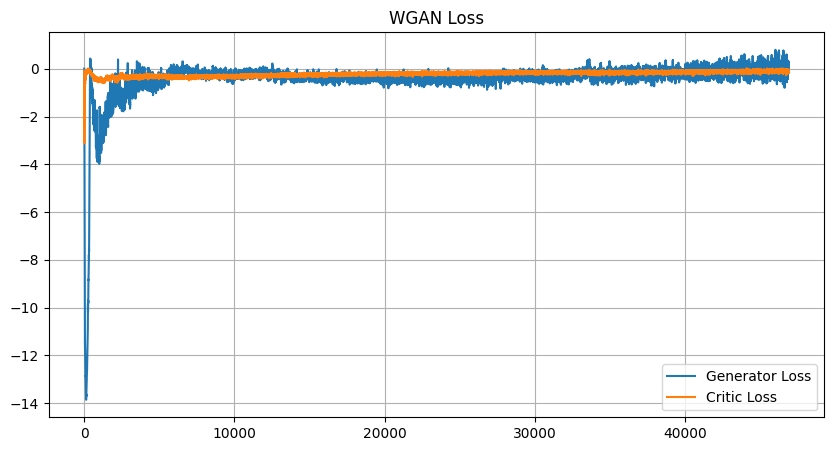

In [5]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(C_losses, label="Critic Loss")
plt.legend()
plt.grid(True)
plt.title("WGAN Loss")
plt.show()

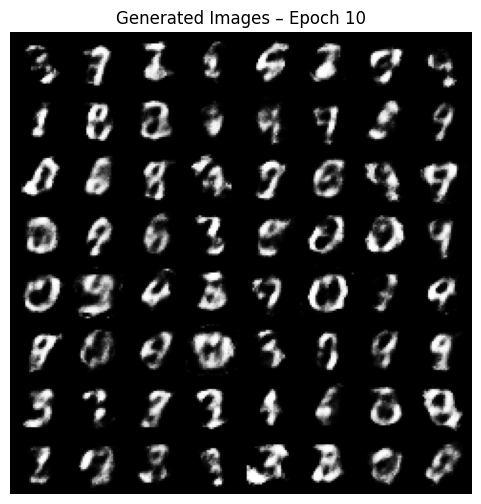

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/mnt/data/wgan/fake_epoch_10.png")

plt.figure(figsize=(6,6))
plt.title("Generated Images – Epoch 10")
plt.axis("off")
plt.imshow(img)
plt.show()
